## Notebook Purpose

Recreate deep decoder experiments run in `ConvDecoder_vs_DIP_vs_DD_multicoil.ipynb`, hereon referred to as the original notebook, which was extremely messy and unnecessarily complicated.

In [1]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

from utils.transform import np_to_tt, np_to_var, apply_mask, ifft_2d, fft_2d, \
                            reshape_complex_channels_to_sep_dimn, \
                            reshape_complex_channels_to_be_adj, \
                            split_complex_vals, combine_complex_channels, \
                            crop_center, root_sum_of_squares
from utils.helpers import num_params
from include.decoder_conv import convdecoder
from include.mri_helpers import get_scale_factor
from include.fit import fit

from pytorch_msssim import ms_ssim
from common.evaluate import vifp_mscale, ssim, psnr

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(0)
#     print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

In [40]:
def recon_ksp_to_img(ksp, dim=320):
    ''' given a 3D npy array (or torch tensor) ksp k-space e.g. shape (15,x,y)
        (1) perform ifft to img space
        (2) reshape/combine complex channels
        (3) combine multiple coils via root sum of squares
        (4) crop center portion of image according to dim
    '''
    
    if type(ksp).__module__ == np.__name__:
        ksp = np_to_tt(ksp)

    arr = ifft_2d(ksp).cpu().numpy()
    arr = reshape_complex_channels_to_be_adj(arr)
    arr = combine_complex_channels(arr) # e.g. shape (30,x,y) --> (15,x,y)
    arr = root_sum_of_squares(arr) # e.g. (15,x,y) --> (x,y)
    arr = crop_center(arr, dim, dim) # e.g. (x,y) --> (dim,dim)
    
    return arr

def normalize_img(img_out, img_gt):
    ''' normalize the pixel values in im_gt according to (mean, std) of im_out
        verified: step is necessary '''
    
    if img_out.mean() < img_gt.mean():
        raise NotImplementedError('assumes img_gt has much smaller pixel vals')

    img_gt = (img_gt - img_gt.mean()) / img_gt.std()
    img_gt *= img_out.std()
    img_gt += img_out.mean()
    
    return img_gt

def calc_metrics(img_out, img_gt):
    ''' compute vif, ssim, and psnr of arr_out using im_gt as ground-truth reference '''
    
    img_gt = normalize_img(img_out, img_gt)
    
    vif_ = vifp_mscale(img_out, img_gt, sigma_nsq=img_out.mean())
    ssim_ = ssim(np.array([img_out]), np.array([img_gt]))
    psnr_ = psnr(np.array([img_out]), np.array([img_gt]))
    
    dt = torch.FloatTensor
    img_out_t = torch.from_numpy(np.array([[img_out]])).type(dt)
    img_gt_t = torch.from_numpy(np.array([[img_gt]])).type(dt)
    msssim_ = ms_ssim(img_out_t, img_gt_t, data_range=img_gt_t.max())
    msssim_ = msssim_.data.cpu().numpy()[np.newaxis][0]
    
    return vif_, msssim_, ssim_, psnr_ 

### Load MRI measurements, y

Isolate individual 2D slice

In [4]:
def load_h5(file_id):
    ''' given file_id, return the h5 file and central slice '''
    
    filename = '/bmrNAS/people/dvv/multicoil_test_v2/file{}_v2.h5'.format(file_id)
    f = h5py.File(filename, 'r') 
    
#     print('file_id {} w ksp shape (num_slices, num_coils, x, y): {}'.format( \
#                                             file_id, f['kspace'].shape))

    # isolate central k-space slice
    slice_idx = f['kspace'].shape[0] // 2
    slice_ksp = f['kspace'][slice_idx]
    
    return f, slice_ksp

### Load mask, M

- Format of loaded mask is 1d binary vector of size ~368, i.e. sampling of vertical lines in image
- Convert mask to 0's and 1's, zero pad, convert to 2D, create torch transform

##### TODO's
- work through this on low-level to simplify steps + reduce number of returned items

Note: See original notebook for generating a new mask, e.g. if .h5 doesn't have a mask

In [5]:
def get_masks(file_h5):
    ''' given h5 file, return three different versions of masks:
            mask: used for masking k-space as network input
            mask2d: 2D mask used to fit network 
            mask1d: 1D mask used for data consistency step '''
    try:
        mask1d = np.array([1 if e else 0 for e in file_h5["mask"]]) # load 1D binary mask
    except:
        print('Implement method for generating a mask')
        sys.exit()

    # zero out mask in outer regions e.g. mask and data have last dimn 368, but actual data is size 320
    # TODO: if actual data is size 320, then why do we have dimn 368?
    idxs_zero = (mask1d.shape[-1] - 320) // 2 # e.g. zero first/last (368-320)/2=24 indices
    mask1d[:idxs_zero], mask1d[-idxs_zero:] = 0, 0

    # create 2d mask. zero pad if dimensions don't line up - is this necessary?
    mask2d = np.repeat(mask1d[None,:], slice_ksp.shape[1], axis=0)#.astype(int)
    mask2d = np.pad(mask2d, ((0,),((slice_ksp.shape[-1]-mask2d.shape[-1])//2,)), mode='constant')

    # convert shape e.g. (368,) --> (1, 1, 368, 1)
    mask = np_to_tt(np.array([[mask2d[0][np.newaxis].T]])).type(torch.FloatTensor)
    #print('under-sampling factor:', round(len(mask1d) / sum(mask1d), 2))
    
    return mask, mask2d, mask1d

### Set up ConvDecoder

##### TODO's
- make separate function that returns net_input given the appropriate scale_factor, i.e. split up mri_helpers.get_scale_factor() into two different functions

In [55]:
def init_convdecoder(slice_ksp, mask):
    ''' parameters: 
                slice_ksp: original, unmasked k-space measurements
                mask: mask used to downsample original k-space
        return:
                net: initialized convdecoder
                net_input: random, scaled input seed 
                ksp_masked: masked measurements to fit
                img_masked: masked image, i.e. ifft(ksp_masked) '''

    in_size = [8,4]
    out_size = slice_ksp.shape[1:] # shape of (x,y) image slice, e.g. (640, 368)
    out_depth = slice_ksp.shape[0]*2 # 2*n_c, i.e. 2*15=30 if multi-coil
    num_layers = 8
    strides = [1]*(num_layers-1)
    num_channels = 160
    kernel_size = 3

    net = convdecoder(in_size, out_size, out_depth, num_layers, \
                      strides, num_channels).type(dtype)
    #print('# parameters of ConvDecoder:',num_params(net))
    
    # fix the scaling b/w original image and random output image = net(input tensor w values ~U[0,1]) 
    # e.g. scale_factor = 168813
    # note: can be done using the under-sampled kspace, but we use the full kspace
    scale_factor, net_input = get_scale_factor(net,
                                       num_channels,
                                       in_size,
                                       slice_ksp)
    slice_ksp = slice_ksp * scale_factor # original fit_untrained() f'n returns this

    # mask the kspace
    ksp_masked = apply_mask(np_to_tt(slice_ksp), mask=mask)
    ksp_masked = np_to_var(ksp_masked.data.cpu().numpy()).type(dtype)

    # perform ifft of masked kspace
    img_masked = ifft_2d(ksp_masked[0]).cpu().numpy()
    img_masked = reshape_complex_channels_to_be_adj(img_masked)
    img_masked = np_to_var(img_masked).type(dtype)
    
    return net, net_input, ksp_masked, img_masked, slice_ksp

### Fit network via `fit(...)`

##### Returns
- net: the best network. network output is in image space but not computed
- mse_wrt_ksp = mse(ksp_masked, fft(out) * mask)
- mse_wrt_img = mse(img_masked, out)

##### args:
- `ksp_masked`: masked k-space of single slice
- `img_masked`: ifft(ksp_masked)
- `img_ls`: least-squares recon of original (unmasked) k-space. This is used only to compute ssim, psnr, and norm_ratio across number of iterations. Too see how this is created, refer to original ipynb for definining `lsimg`

Note: Original code has opt_input argument (default False) which would hence return a new version of net_input

##### TODO's (in fit.py)
- make apply_f call less confusing. compare forwardm to utils.transform.apply_mask()
- understand why we backprop on loss_ksp and not loss_img
- what is difference b/w "image loss" and "image loss orig"?

##### Findings:
- When evaluating on one image, 1000 iterations was sufficient. Seemingly no benefit running for 10000 images
- Runtime per iteration is ~ 0.125s --> ~125s per 1000 iterations. Most expensive steps:
    - backprop loss_ksp: ~0.085s
    - compute net output: ~0.025s
    - all the rest combined: ~0.015s
- Cut down runtime by ~15% by removing unnecessary data type conversions
- Can cut down runtime by ~20% using HalfTensor. In order to implement this, must do the following:
    - Uncomment casting lines below
    - Add apply_f(...).half() in loss_ksp calc of fit.py
    - After all this, gradients go to zero because their values are small and cannot be represented in fp16. As such, follow the blog post under "Mixed-Precision Training Iteration" at https://developer.nvidia.com/blog/mixed-precision-training-deep-neural-networks/. Note: cannot use autocast, as it currently isn't supported in the main version of pytorch
    - Once that works, need to verify no loss in output image quality

In [7]:
## UNCOMMENT for half precision and INJECT before fitting network
# net = net.half()
# ksp_masked = ksp_masked.half()
# img_masked = img_masked.half()
# mask = mask.half()
# dtype=torch.cuda.HalfTensor

In [8]:
# plt.plot(mse_wrt_ksp, label='ksp')
# plt.plot(mse_wrt_img, label='img')
# plt.ylim(0, 0.05)

# TODO: fix method for computing gt

currently we see that mse_wrt_ksp and mse_wrt_img decrease as NUM_ITER increases. However, ssim and psnr computed with img_gt actually get worse as NUM_ITER increases. Must not be computing img_gt correctly

current method: perform ifft of original k-space ksp_orig, combine complex values, combine multi-channel via rss (same method for recon of ksp_dc and ksp_est)

### Perform data consistency step

Compute network output, convert to k-space and perform data-consistency step, then convert back to image space

What is actually happening in this dc step?
- 41/368 of mask coefficients are set to true 
- 41 columns, e.g. 41 * 640 = 787200 of values in ksp are overwritten

##### TODO:
- check and reduce redundant computations, i.e. here we subsample k-space again

In [9]:
def data_consistency(img_out, slice_ksp, mask1d):
    ''' perform data-consistency step so no 
        parameters:
                img_out: network output image, shape torch.Size([30, x, y])
                slice_ksp: original k-space measurements 
        returns:
                img_dc: data-consistent output image
                img_est: output image without data consistency '''
    
    img_out = reshape_complex_channels_to_sep_dimn(img_out)

    # now get F*G(\hat{C}), i.e. estimated recon in k-space
    ksp_est = fft_2d(img_out) # ([15, 640, 368, 2])
    ksp_orig = np_to_tt(split_complex_vals(slice_ksp)) # ([15, 640, 368, 2]); slice_ksp (15,640,368) complex

    # replace estimated coeffs in k-space by original coeffs if it has been sampled
    mask1d = torch.from_numpy(np.array(mask1d, dtype=np.uint8)) # shape: torch.Size([368]) w 41 non-zero elements
    ksp_dc = ksp_est.clone().detach().cpu()
    ksp_dc[:,:,mask1d==1,:] = ksp_orig[:,:,mask1d==1,:]

    img_dc = recon_ksp_to_img(ksp_dc)
    img_est = recon_ksp_to_img(ksp_est.detach().cpu())
    
    return img_dc, img_est

In [ ]:
# file_id_list = '1000411' #'1000781'
file_id_list = ['1000186', '1000361', '1001524', '1000799', '1001152', '1001132']#, '1001826', '1000522']
  
img_dc_list, img_est_list, img_gt_list, metrics_dc = [], [], [], []

# NUM_ITER = 1000  
NUM_ITER_LIST = [1, 1000]

for idx, file_id in enumerate(file_id_list):  
    
    f, slice_ksp = load_h5(file_id)
    if f['kspace'].shape[3] == 320:
        continue
    print('file_id: {}'.format(file_id))

    mask, mask2d, mask1d = get_masks(f)

    for NUM_ITER in NUM_ITER_LIST:
    
        net, net_input, ksp_masked, img_masked, slice_ksp = \
                init_convdecoder(slice_ksp, mask)

        net, mse_wrt_ksp, mse_wrt_img = fit(
            ksp_masked=ksp_masked, img_masked=img_masked,
            net=net, net_input=net_input, mask=mask2d,
            img_ls=None, num_iter=NUM_ITER, dtype=dtype)

        img_out = net(net_input.type(dtype))[0] # estimate image \hat{x} = G(\hat{C})

        img_dc, img_est = data_consistency(img_out, slice_ksp, mask1d)
        img_gt = recon_ksp_to_img(slice_ksp) # must do this after slice_ksp is scaled

        img_dc_list.append(img_dc)
        if NUM_ITER == np.array(NUM_ITER_LIST).min():
            img_est_list.append(img_est)
            img_gt_list.append(img_gt)
#     metrics_dc.append(calc_metrics(img_dc, img_gt))
        
# img_dc_list = np.array(img_dc_list)

file_id: 1000186
file_id: 1000361


In [ ]:
KEY_WORD = '' #'iter{}'.format(NUM_ITER)

for i in np.arange(len(file_id_list)):
    
    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(141)
    ax1.imshow(img_gt_list[i], cmap='gray')
    ax1.set_title('ground-truth?')
    ax1.axis('off')

    ax2 = fig.add_subplot(142)
    ax2.imshow(img_dc_list[i], cmap='gray')
    ax2.set_title('conv_decoder, iter {}'.format(np.array(NUM_ITER_LIST).min()))
    ax2.axis('off')

    ax3 = fig.add_subplot(143)
    ax3.imshow(img_dc_list[i+1], cmap='gray')
    ax3.set_title('conv_decoder')
    ax3.axis('off')
    
    ax4 = fig.add_subplot(144)
    ax4.imshow(img_est_list[i], cmap='gray')
    ax4.set_title('conv_decoder w/o dc post')
    ax4.axis('off')
    
    plt.savefig('png_out/sample{}_{}.png'.format(i, KEY_WORD))
    plt.show()

# TODO 16 September    
- get baseline performance over e.g. 10 images
- implement data consistency in last layer; compare performance to the same 10 images
- review papers sent by akshay



- data consistency in the loss
    - need to implement dc step into torch variables (done in numpy above)
    - then i can call this similar to how apply_f()=forwardm() is done in current `fit.py`
- next step: how to do layer-wise data consistency?

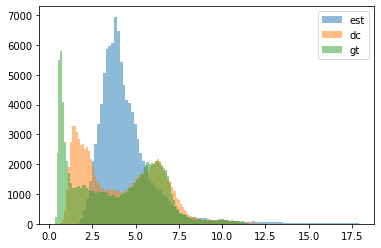

In [57]:
img_gt_shifted = img_gt * (img_dc.mean() / img_gt.mean())

# est is output image without data consistency step
plt.hist(img_est.flatten(), bins=100, alpha=0.5, label='est')
plt.hist(img_dc.flatten(), bins=100, alpha=0.5, label='dc')
plt.hist(img_gt.flatten(), bins=100, alpha=0.5, label='gt')
plt.legend()
plt.show()